<a href="https://colab.research.google.com/github/SenolIsci/ML-Model-Starters/blob/main/multi_input_multi_output_image_tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#One-input Multi-output Model with Tensorflow Keras Functional API

To demonstrate, we will use MNIST which is a handwritten dataset. It's normally a 10 class classification problem data set. From it, we will create an additionally 2 class classifier (whether a digit is even or odd) and also a 1 regression part (which is to predict the square of a digit, i.e for image input of 9, it should give approximately it's square).


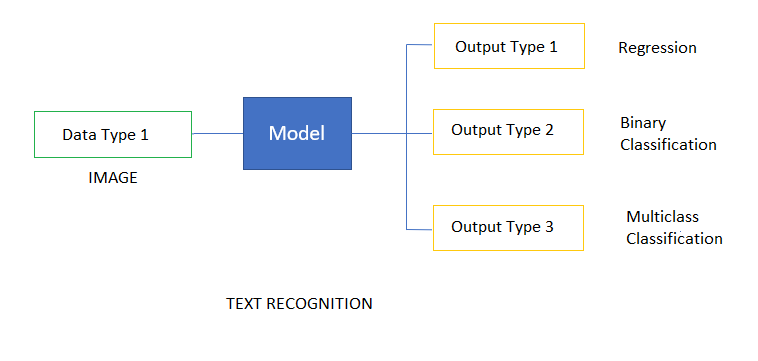

Imports

In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from keras import layers



Dataset

In [3]:

(xtrain, ytrain), (_, _) = keras.datasets.mnist.load_data()

# 10 class classifier 
y_out_a = keras.utils.to_categorical(ytrain, num_classes=10) 

# 2 class classifier, even or odd 
y_out_b = keras.utils.to_categorical((ytrain % 2 == 0).astype(int), num_classes=2) 

# regression, predict square of an input digit image
y_out_c = tf.square(tf.cast(ytrain, tf.float32))

In [8]:

ytrain

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

So, our training pairs will be xtrain and [y_out_a, y_out_b, y_out_c].

In [7]:
#one hot encoded targets
y_out_a.shape,y_out_b.shape,y_out_c.shape

((60000, 10), (60000, 2), TensorShape([60000]))

## Model Building

Let's build the model accordingly using the Functional API of tf. keras. See the model definition below. The MNIST samples are a 28 x 28 grayscale image. So our input is set in that way. I'm guessing your data set is probably RGB, so change the input dimension accordingly.


In [60]:

input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
x = layers.GlobalMaxPooling2D()(x)

out_a = keras.layers.Dense(10, activation='softmax', name='10cls')(x)
out_b = keras.layers.Dense(2, activation='softmax', name='2cls')(x)
out_c = keras.layers.Dense(1, activation='linear', name='1rg')(x)

encoder = keras.Model( inputs = input, outputs = [out_a, out_b, out_c], name="encoder")

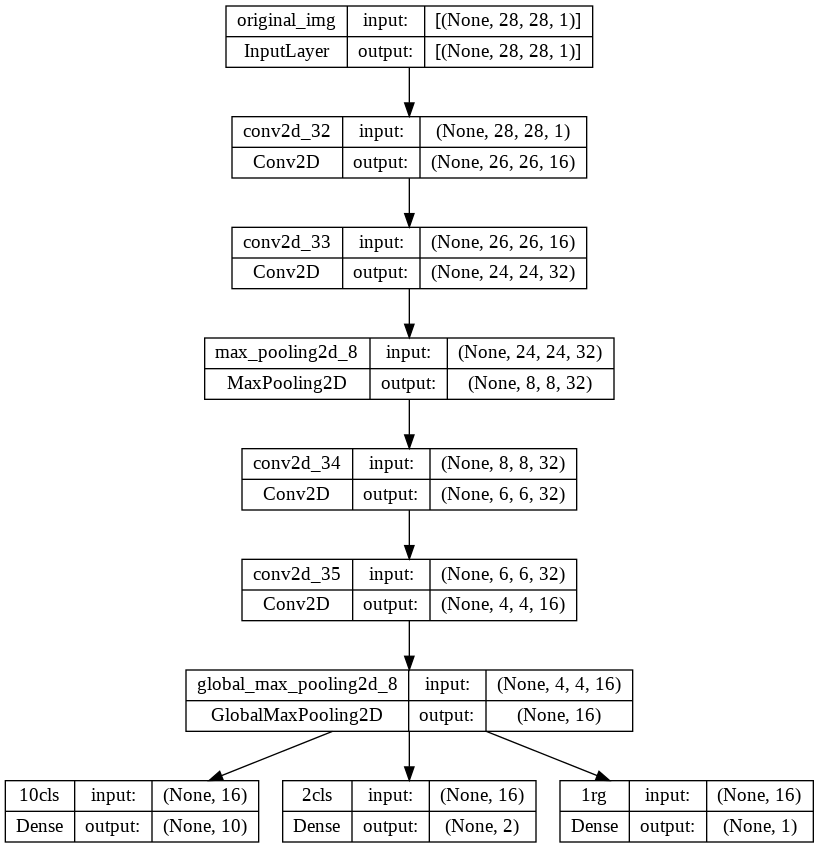

In [61]:
# Let's plot 
keras.utils.plot_model(
    encoder,show_shapes=True
)

Compile and Run

Now, we can see why that name variable is important. In order to run the model, we need to compile it first with the proper loss function, metrics, and optimizer. Now, if you know that, for the classification and regression problem, the optimizer can be the same but for the loss function and metrics should be changed. And in our model, which has a multi-type output model (2 classifications and 1 regression), we need to set proper loss and metrics for each of these types. Please, see below how it's done.

In [62]:
encoder.compile(
    loss = {
        "10cls": tf.keras.losses.CategoricalCrossentropy(),
        "2cls": tf.keras.losses.CategoricalCrossentropy(),
        "1rg": tf.keras.losses.MeanSquaredError()
    },

    metrics = {
        "10cls": 'accuracy',
        "2cls": 'accuracy',
        "1rg": 'mse'
    },

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [63]:
history=encoder.fit(xtrain, [y_out_a, y_out_b, y_out_c], epochs=3, verbose=2)

Epoch 1/3
1875/1875 - 82s - loss: 124.3774 - 10cls_loss: 3.1567 - 2cls_loss: 1.4381 - 1rg_loss: 119.7825 - 10cls_accuracy: 0.5993 - 2cls_accuracy: 0.8063 - 1rg_mse: 119.7825 - 82s/epoch - 44ms/step
Epoch 2/3
1875/1875 - 78s - loss: 62.1941 - 10cls_loss: 0.5139 - 2cls_loss: 0.2846 - 1rg_loss: 61.3955 - 10cls_accuracy: 0.8807 - 2cls_accuracy: 0.9064 - 1rg_mse: 61.3955 - 78s/epoch - 41ms/step
Epoch 3/3
1875/1875 - 79s - loss: 49.9599 - 10cls_loss: 0.3156 - 2cls_loss: 0.1800 - 1rg_loss: 49.4642 - 10cls_accuracy: 0.9244 - 2cls_accuracy: 0.9324 - 1rg_mse: 49.4642 - 79s/epoch - 42ms/step


##Loss Weights

It's possible to give different weights to different output-specific losses (for instance, one might wish to privilege the "10cls" loss in our example, by giving to 2x the importance of the class loss), using the loss_weights argument:



    loss_weights = {
        "10cls": 2.,
        "2cls": 1.,
        "1rg": 1.
     }
    
   


There is an essential parameter while .compile the model which you might need: loss_weights - to weight the loss contributions of different model outputs. 



There is an essential parameter while .compile the model which you might need: loss_weights - to weight the loss contributions of different model outputs. 
    
    encoder.compile(
    ... ,  loss_weights = {
        "10cls": 2.,
        "2cls": 1.,
        "1rg": 1.
     })


 The total loss is the result of 1.* 10cls + 1.* 2cls + 1. *1rg. 

##Prediction / Inference

Let's see some output. We now hope this model will predict 3 things: (1) is what the digit is, (2) is it even or odd, and (3) its square value.

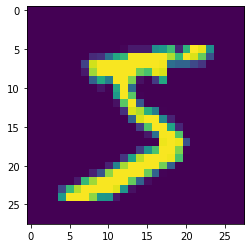

In [64]:
import matplotlib.pyplot as plt
plt.imshow(xtrain[0])

If we like to quickly check the output layers of our model


In [65]:
encoder.output

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer '10cls')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer '2cls')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '1rg')>]

In [66]:
# we expand for a batch dimension: (1, 28, 28, 1)
pred10, pred2, pred1 = encoder.predict(tf.expand_dims(xtrain[0], 0))


1/1 [==============================] - 0s 91ms/step


In [67]:
# regression: square of the input dgit image 
pred1 


array([[19.882915]], dtype=float32)

In [68]:
# even or odd, surely odd 
pred2.argmax()


0

In [69]:
# which number, surely 5
pred10.argmax()


5

#Multi-input Multi-output Model with Tensorflow Keras Functional API

We can extend the one-input Multi-output model to take multi-input too. We need to change things. To demonstrate, we will use train and test samples of the mnist data set to the model as a multi-input.

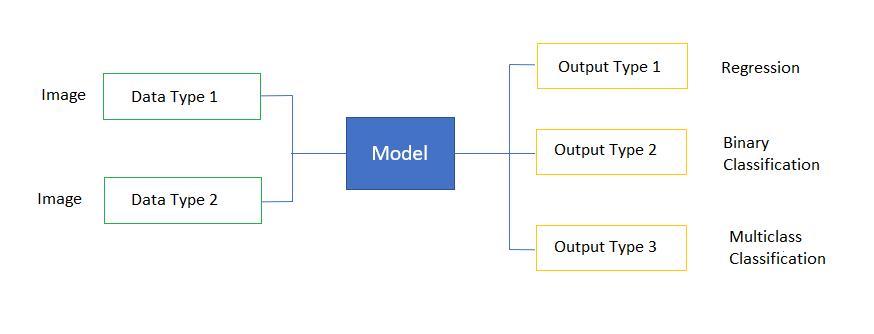

Imports

In [70]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from keras import layers


Dataset

In [71]:
(xtrain, ytrain), (xtest, _) = keras.datasets.mnist.load_data()

xtrain = xtrain[:10000] # both input sample should be same number 
ytrain = ytrain[:10000] # both input sample should be same number


In [72]:
y_out_a = keras.utils.to_categorical(ytrain, num_classes=10)
y_out_b = keras.utils.to_categorical((ytrain % 2 == 0).astype(int), num_classes=2)
y_out_c = tf.square(tf.cast(ytrain, tf.float32))

print(xtrain.shape, xtest.shape) 
print(y_out_a.shape, y_out_b.shape, y_out_c.shape)

(10000, 28, 28) (10000, 28, 28)
(10000, 10) (10000, 2) (10000,)


##Model Building
Next, we need to modify some parts of the above model to take multi-input. And next if you now plot, you will see the new graph.

In [73]:
input0 = keras.Input(shape=(28, 28, 1), name="img2")
input1 = keras.Input(shape=(28, 28, 1), name="img1")
concate_input = layers.Concatenate(name="concate_input")([input0, input1])

x = layers.Conv2D(16, 3, activation="relu")(concate_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
x = layers.GlobalMaxPooling2D()(x)

out_a = keras.layers.Dense(10, activation='softmax', name='10cls')(x)
out_b = keras.layers.Dense(2, activation='softmax', name='2cls')(x)
out_c = keras.layers.Dense(1, activation='linear', name='1rg')(x)

encoder = keras.Model( inputs = [input0, input1], outputs = [out_a, out_b, out_c], name="encoder")

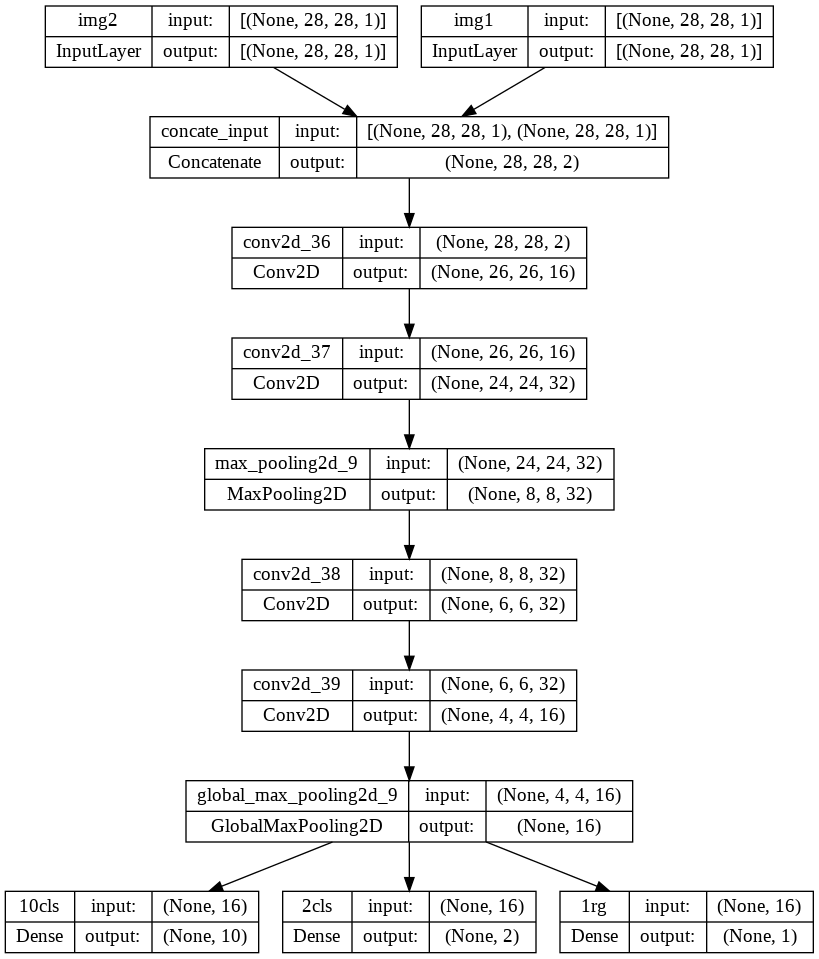

In [74]:
# Let's plot 
keras.utils.plot_model(
    encoder,show_shapes=True
)

In [75]:
encoder.compile(
    loss = {
        "10cls": tf.keras.losses.CategoricalCrossentropy(),
        "2cls": tf.keras.losses.CategoricalCrossentropy(),
        "1rg": tf.keras.losses.MeanSquaredError()
    },

    metrics = {
        "10cls": 'accuracy',
        "2cls": 'accuracy',
        "1rg": 'mse'
    },

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

Now, we can train the model as follows

In [76]:
# multi-input, multi-output
history=encoder.fit([xtrain, xtest], [y_out_a, y_out_b, y_out_c], 
             epochs=3, batch_size = 256, verbose=2)

Epoch 1/3
40/40 - 12s - loss: 1336.2705 - 10cls_loss: 47.4589 - 2cls_loss: 11.0047 - 1rg_loss: 1277.8065 - 10cls_accuracy: 0.1016 - 2cls_accuracy: 0.4959 - 1rg_mse: 1277.8065 - 12s/epoch - 295ms/step
Epoch 2/3
40/40 - 10s - loss: 670.1013 - 10cls_loss: 28.4387 - 2cls_loss: 2.3663 - 1rg_loss: 639.2964 - 10cls_accuracy: 0.1033 - 2cls_accuracy: 0.5218 - 1rg_mse: 639.2964 - 10s/epoch - 255ms/step
Epoch 3/3
40/40 - 10s - loss: 492.9694 - 10cls_loss: 16.8313 - 2cls_loss: 4.3306 - 1rg_loss: 471.8075 - 10cls_accuracy: 0.0889 - 2cls_accuracy: 0.5589 - 1rg_mse: 471.8075 - 10s/epoch - 254ms/step


##Prediction / Inference
Let's see some output. We now hope this model will predict 3 things: (1) is what the digit is, (2) is it even or odd, and (3) its square value.
Now, we can test the multi-input model and get multi-out from it.


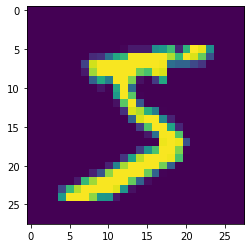

In [77]:
import matplotlib.pyplot as plt
plt.imshow(xtrain[0])

In [78]:
pred10, pred2, pred1 = encoder.predict(
    [
         tf.expand_dims(xtrain[0], 0),
         tf.expand_dims(xtrain[0], 0)
    ]
)



1/1 [==============================] - 0s 95ms/step


In [79]:
# regression part 
pred1

array([[21.538872]], dtype=float32)

In [80]:
# even or odd 
pred2.argmax()

0

In [81]:
# what digit 
pred10.argmax()

7